---
# Mega script
---

In [7]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd

# Set correct working directory
if os.getcwd() != os.path.abspath("../Python"):
    os.chdir("../../Python")

import tools
from matplotlib import pyplot as plt
from confusion_matrix import confusion_matrix
from sklearn.metrics import confusion_matrix as cf

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cmr"
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


----
# Configuration
It should only be needed to change stuff in this section

----

In [8]:
config = {
    "standardize" : True,
    "lda_reduce" : 5,
    "classifier" : "qda",
    "keep_features" : 7,
    "drop_faults" : False,
    "use_only_faults" : False,
    "use_only_features" : False,
    "direction" : "backward",
    "even_sample" : False,
    "frac_sample" : 0.5,
    "random_state" : 1,
    "conf_size" : (10,10)
}

svm_args = {
    'C':1000,
    'gamma':0.01, 
    'decision_function_shape':"ovo",
}

----

In [9]:
# Load data sets
trn = tools.dataloader("../TrainingData/neodata/soltani_14d_nonoise_1200.csv",'target')
vld = tools.dataloader("../ValidationData/neodata/soltani_14d_nonoise_1200.csv",'target')
tst = tools.dataloader("../TestData/neodata/soltani_14d_nonoise_100.csv",'target')

trn = trn.drop({'target':config["drop_faults"]}) if config["drop_faults"] else trn
vld = vld.drop({'target':config["drop_faults"]}) if config["drop_faults"] else vld
tst = tst.drop({'target':config["drop_faults"]}) if config["drop_faults"] else tst

trn = trn.get({'target':config["use_only_faults"]}) if config["use_only_faults"] else trn
vld = vld.get({'target':config["use_only_faults"]}) if config["use_only_faults"] else vld
tst = tst.get({'target':config["use_only_faults"]}) if config["use_only_faults"] else tst

----
## Standardize data

In [10]:
import standardization
scaler = standardization.scaler(trn.X)

trn_std = trn.apply(scaler.transform)  if config["standardize"] else trn
vld_std = vld.apply(scaler.transform)  if config["standardize"] else vld
tst_std = tst.apply(scaler.transform)  if config["standardize"] else tst

----
## Classifier definitions

In [11]:
def classifier(classifier_select):
    if classifier_select == "qda":
        from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
        return QuadraticDiscriminantAnalysis()

    elif classifier_select == "lda":
        from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
        return LinearDiscriminantAnalysis()

    elif classifier_select == "svm":
        from sklearn import svm
        return svm.SVC( **svm_args )

    elif classifier_select == "qda_self":
        import qda
        return qda.classifier()

    elif classifier_select == "lda_self":
        import lda
        return lda.classifier()

----
## Feature selection

In [12]:
kwargs = {
    'clf' : classifier(config["classifier"]),
    'trn' : trn_std.sample(even = config["even_sample"], frac=config["frac_sample"],random_state = config["random_state"]),
    'vld' : vld_std.sample(even = config["even_sample"], frac=config["frac_sample"],random_state = config["random_state"])
}

# Caching of feature selection if classifier is unchanged
if not config["use_only_features"]:
    if not 'summary' in globals() or not 'summary' in globals():
        cached_config = config
        summary = tools.feature_selection(**kwargs)
    if 'cached_config' in globals():
        if (cached_config[ "classifier"] != config[ "classifier"]) or \
        (cached_config["frac_sample"] != config["frac_sample"]) or \
        (cached_config["standardize"] != config["standardize"]) or \
        (cached_config["even_sample"] != config["even_sample"]) :
            cached_config = config
            summary = tools.feature_selection(**kwargs)

In [15]:
features = config["use_only_features"] if config["use_only_features"] else summary[(summary["n_features"] == config["keep_features"]) & (summary["direction"] == config["direction"])]["features"].tolist()
print(f"Keeping : { features }")

trn_drop = trn_std.get(features) if config["keep_features"] else trn_std
vld_drop = vld_std.get(features) if config["keep_features"] else vld_std
tst_drop = tst_std.get(features) if config["keep_features"] else tst_std

Keeping : ['Tamb', 'Tset']


----
## LDA dimensionality reduction

### Try all possibilities of LDA reduction

In [8]:
import lda

lda_accuracy = []
for dimensions in range(1,len(trn_drop.X.columns)):
    
    reducer = lda.reducer(trn_drop.X,trn_drop.y, dimensions, verbose = False)

    trn_red = trn_drop.apply(reducer.transform).sample(even = config["even_sample"], frac=config["frac_sample"],random_state = config["random_state"])
    vld_red = vld_drop.apply(reducer.transform).sample(even = config["even_sample"], frac=config["frac_sample"],random_state = config["random_state"])
    
    clf = classifier(config["classifier"])
    clf.fit(trn_red.X,trn_red.y)

    lda_accuracy.append( sum(clf.predict(vld_red.X) == vld_red.y)/len(vld_red.y) )

clf.fit(trn_drop.X,trn_drop.y)
lda_accuracy.append( sum(clf.predict(vld_drop.X) == vld_drop.y)/len(vld_drop.y) )

### Do actual reduction according to config

In [9]:
reducer = lda.reducer(trn_drop.X,trn_drop.y,config["lda_reduce"])

trn_red = trn_drop.apply(reducer.transform) if config["lda_reduce"] else trn_drop
tst_red = tst_drop.apply(reducer.transform) if config["lda_reduce"] else tst_drop
vld_red = vld_drop.apply(reducer.transform) if config["lda_reduce"] else vld_drop

Conditioning number of Sw : 112.70756075686121
Preserving 100.0% of variance


----
# Classification of feature selected data

In [10]:
# Define naming strings
str_feature = f"FS{x}-" if (x:=config["keep_features"]) else ""
str_classifier = f"{x}" if (x:=config["classifier"].upper()) else ""

# Train classifier
clf = classifier(config["classifier"])
clf.fit(trn_drop.X,trn_drop.y);

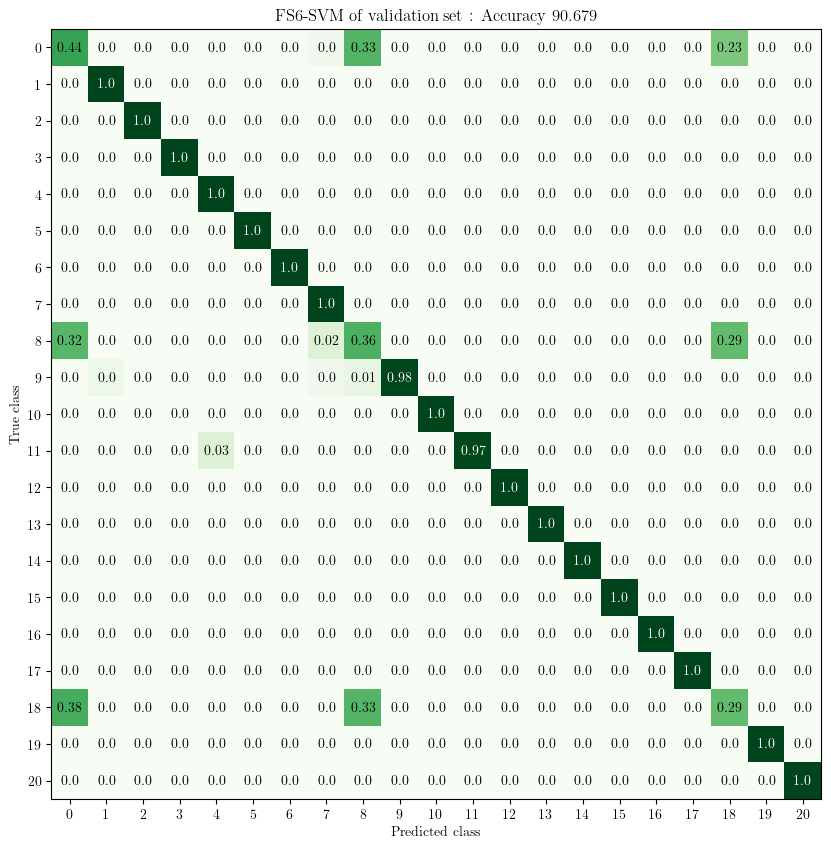

In [11]:
# Make predictions for the training set
y_hat_vld = clf.predict(vld_drop.X)

#plot the confusion matrix
conf_matrix_vld = cf(vld_drop.y,y_hat_vld)
fig_vld1, axs_vld1 = confusion_matrix(
    conf_matrix_vld,
    figsize = config["conf_size"],
    title = f'{str_feature}{str_classifier} of validation set',
    save_fig_name = f'{str_feature}{str_classifier}-validation.pdf')

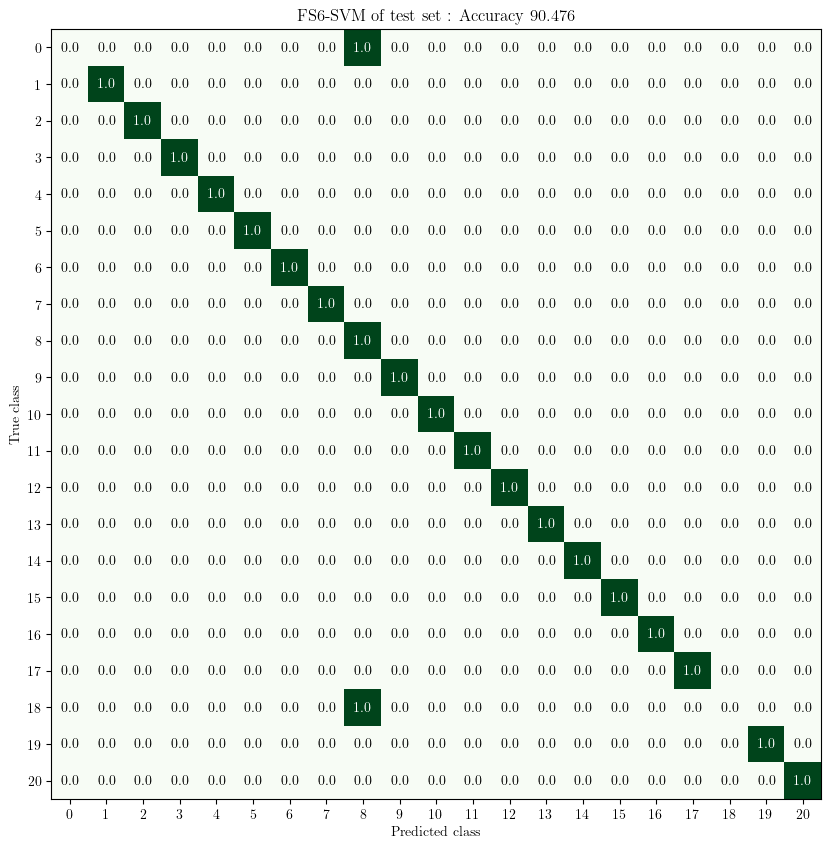

In [12]:
# Make predictions for the training set
y_hat_tst = clf.predict(tst_drop.X)

#plot the confusion matrix
conf_matrix_tst = cf(tst_drop.y,y_hat_tst)
fig_tst1, axs_tst1 = confusion_matrix(
    conf_matrix_tst,
    figsize = config["conf_size"],
    title = f'{str_feature}{str_classifier} of test set',
    save_fig_name = f'{str_feature}{str_classifier}-test.pdf')

----
# Classification on LDA-reduced data

In [13]:
# Define naming strings
str_feature = f"FS{x}-" if (x:=config["keep_features"]) else ""
str_lda = f"LDA{x}-" if (x:=config["lda_reduce"]) else ""
str_classifier = f"{x}" if (x:=config["classifier"].upper()) else ""

# Train classifier
clf = classifier(config["classifier"])
clf.fit(trn_red.X,trn_red.y);

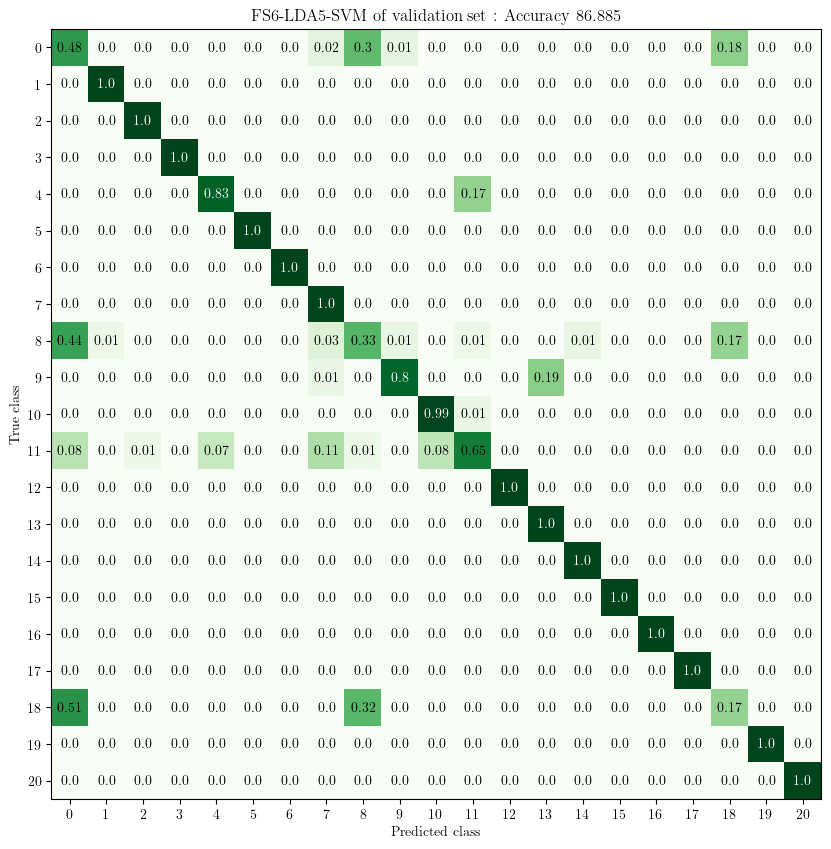

In [14]:
# Make predictions for the training set
y_hat_vld = clf.predict(vld_red.X)

#plot the confusion matrix
conf_matrix_vld = cf(vld_red.y,y_hat_vld)
fig_vld2, axs_vld2 = confusion_matrix(
    conf_matrix_vld,
    figsize = config["conf_size"],
    title = f'{str_feature}{str_lda}{str_classifier} of validation set',
    save_fig_name = f'{str_feature}{str_lda}{str_classifier}-validation.pdf')

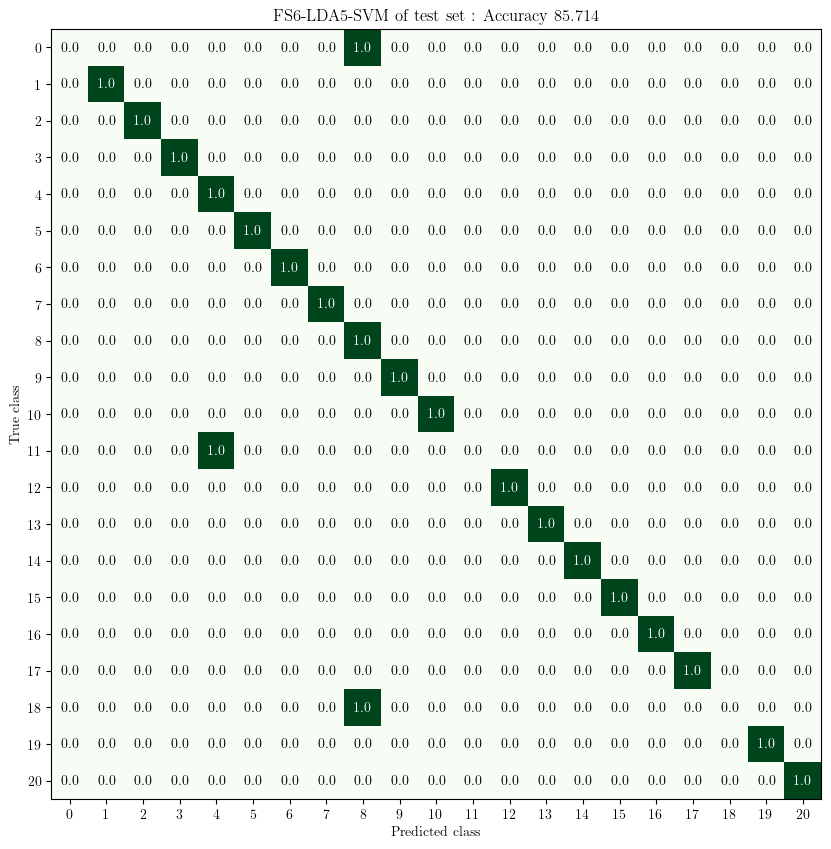

In [15]:
# Make predictions for the training set
y_hat_tst = clf.predict(tst_red.X)

#plot the confusion matrix
conf_matrix_tst = cf(tst_red.y,y_hat_tst)
fig_tst2, axs_tst2 = confusion_matrix(
    conf_matrix_tst,
    figsize = config["conf_size"],
    title = f'{str_feature}{str_lda}{str_classifier} of test set',
    save_fig_name = f'{str_feature}{str_lda}{str_classifier}-test.pdf');

----
# Extra plots

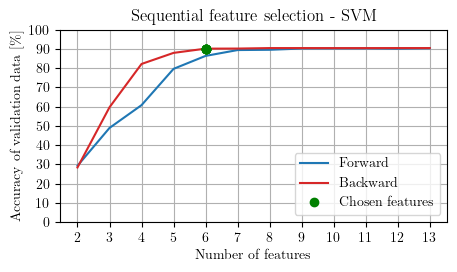

In [16]:
import matplotlib
col = matplotlib.colormaps['tab20']
colors = {'forward': col.colors[0], 'backward': col.colors[6]}

fig,axs = plt.subplots(figsize=(5,2.5))

# Plot feature selection
for j in ["Forward","Backward"]:
    plot_data = summary.loc[summary['direction'] == j.lower()]
    axs.plot(plot_data['n_features'],plot_data['score']*100, label = j,c=colors[j.lower()])

plot_data = summary.loc[summary['direction'] == config["direction"]]

feat = plot_data['n_features'][plot_data['n_features'] == config["keep_features"]]
data = plot_data['score'][plot_data['n_features'] == config["keep_features"]]*100
axs.plot(feat,data,'o',c="green",label = "Chosen features")
axs.set_ylabel('Accuracy of validation data [\%]')
axs.set_xlabel('Number of features')
axs.set_ylim([0,100])
axs.set_title(f'Sequential feature selection - {config["classifier"].upper()}')
axs.grid(True)
axs.legend(loc = 'lower right')
axs.set_xticks(range(2,14));
axs.set_yticks([x*10 for x in range(0,11)]);
fig.savefig(f"{str_feature}{str_classifier}-feature-selection.pdf",bbox_inches='tight')

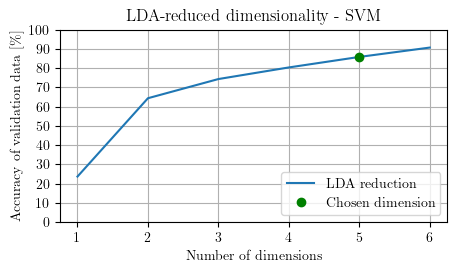

In [17]:
# Plot LDA reduction
fig,axs = plt.subplots(figsize=(5,2.5))
axs.plot(range(1,len(lda_accuracy)+1),np.array(lda_accuracy)*100,label = "LDA reduction")
axs.plot(config["lda_reduce"],lda_accuracy[config["lda_reduce"]-1]*100,'o',c="green",label = "Chosen dimension")
axs.set_title(f'LDA-reduced dimensionality - {config["classifier"].upper()}')
axs.set_xticks(range(1,len(lda_accuracy)+1))
axs.set_xlabel("Number of dimensions")
axs.set_ylabel("Accuracy of validation data [\%]")
axs.set_ylim([20,100])
axs.set_yticks([x*10 for x in range(0,11)]);
axs.legend(loc = 'lower right')
axs.grid()
fig.savefig(f"{str_feature}{str_lda}{str_classifier}-dim-reduction.pdf",bbox_inches='tight')